# CS182 Project: Introduction to EfficientNet


### Part1: introduction
EfficientNet is a family of convolutional neural networks that were designed to provide state-of-the-art accuracy on image classification tasks while maintaining a high level of efficiency. Developed by a team of researchers at Google, EfficientNet models use a novel compound scaling method to balance the number of parameters in the network with its depth and width, resulting in a highly optimized architecture that achieves superior performance with fewer computational resources. EfficientNet models have achieved top scores in various computer vision benchmarks, including the ImageNet dataset, and have been widely adopted for a range of applications, including object detection, segmentation, and transfer learning.

In this HW, we're going to implement EfficientNet from scratch, and understand how EfficientNets are "efficient" in the sense of cost of compuation and number of parameters

Imports and preparations: (Run the cell below if you're using Google Colab)

```python

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_PATH = '/content/gdrive/My\ Drive/cs182project_eq_efficientnet'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182project_eq_efficientnet'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

ModuleNotFoundError: No module named 'google'

In [36]:
!pip install graphviz 
!apt-get install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 631.0 kB/s eta 0:00:00a 0:00:01
zsh:1: command not found: apt-get


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

# Torch stuff
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.utils as utils
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision

import os, random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#training part
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
import logging
import argparse
import random
import copy

import json
import graphviz
from itertools import tee

We're going to use CIFAR-10 dataset for this project. It is very commonly used while testing certain CV models. The dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. We're going to use the torchvision package to load the dataset. The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

In this part we're going to implement a dataloader. The purpose of this is to build a convenient way to feed data from a dataset to a model during training or inference. With the DataLoader, users can easily handle large datasets and apply different data augmentation techniques to the input data. The PyTorch DataLoader is a flexible and efficient tool that has become a standard part of many deep learning workflows.

In [5]:
'''
Feel free to come back and modify some of this part. These transformations are used for data augmentation.
'''
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)



In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
train_size, val_size = 40000, 10000
train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

Question 1a): setup train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset in the following block. You can use the code in the previous block as a reference.
Hint: check out function: produce_dataloader_dataset

In [9]:
#######################
# TODO: your code here#
#######################
trainloader = DataLoader(train_ds, batch_size=256,
                            shuffle=True, num_workers=2)
valloader = DataLoader(val_ds, batch_size=256, 
                            shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=256,
                            shuffle=False, num_workers=2)
#######################
#END OF YOUR CODE    #
#######################

/Users/tianyuecheng/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tianyuecheng/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <9E417059-FF86-3C93-B8D5-8A071C12B008> /Users/tianyuecheng/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <FCDF8FF0-BE97-3626-A00F-72BE6AC59BB9> /Users/tianyuecheng/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/tianyuecheng/opt/anaconda3/envs/notebook/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tianyue

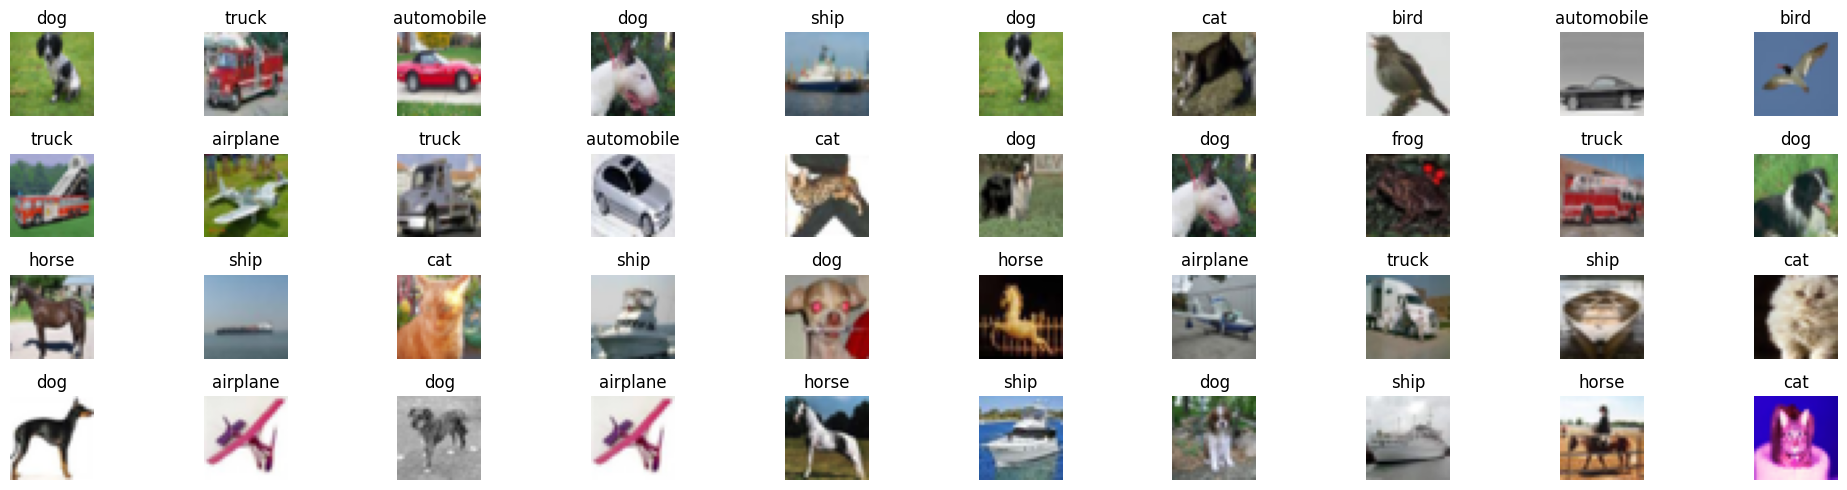

In [29]:
'''
You should be able to see some sample images from the training set if you correctly implemented the above code.
'''
def draw_sample_images(data, labels):
    nrows = 4
    ncols = 10
    total_image = data.shape[0]
    samples = np.random.choice(total_image, nrows*ncols)
    plt.figure(figsize=(20, 5))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        image = np.moveaxis(data[samples[i]].numpy(), 0, -1)
        plt.imshow(image/2+0.5)
        plt.title(trainset.classes[labels[samples[i]]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

data_iterator = iter(trainloader)
images, labels = next(data_iterator)
draw_sample_images(images, labels)

In [30]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [32]:
trainloader

Question: What's the shape of data in train_loader for a sigle batch? (in terms of [N, C, H, W])

Answer: 60000, 3, 32, 32

### Part 2: Building the model


The "highlight" of EfficientNet is its use of compound scaling methods. Compound scaling in essence is to use a coefficient to uniformaly scale the 3 Dimensions (depth, width and resolution) of the model. The coefficient is denoted as $\phi$ in the paper. The scaling method is as follows:

$$
 depth: d = \alpha^\phi \\
 width: w = \beta^\phi \\
 resolution: r = \gamma^\phi \\
 \alpha \cdot \beta^2 \cdot \gamma ^2 \approx 2\\
\alpha \geq 1, \beta \geq 1, \gamma \geq 1

$$ 

The author created a family of EfficientNet models with different $\phi$ values, and the best model is EfficientNet-B7 with $\phi = 2.0$. In this HW, we're going to implement EfficientNet-B0 with $\phi = 1.0$, which is the smallest model in the family.

Firstly we'going to implement some tricks the author used that makes EfficientNet efficient. The first technique is called Squeeze and Excitation (SE). SE is very similiar to the attention mechanism. It is used to help the model to focus on the most important features. The SE module is implemented as follows: 

![image](https://github.com/charlietcheng/Intro-to-EfficientNet/blob/main/imgs/SE.jpeg?raw=1)

In [14]:
# Implement the Squueze and Excitation block down below
# Note that though the image above shows we're using ReLu as the activation function, we're actually using SiLU (swish)
# as the author mentioned in the paper that it performed better than ReLU. We also replace the avgpool with adaptiveavgpool
# for the same reason.
# Hint: use nn.AdaptiveAvgPool2d(1) to replace nn.AvgPool2d(1) and nn.SiLU() to replace nn.ReLU()
class SqueezeExcitation(nn.Module):
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        #######################
        # TODO: your code here#
        #######################
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
        #######################
        # End of your code    #
        #######################
    
    def forward(self, x):
        #######################
        # TODO: your code here#
        #######################
        y = self.se(x)
        #######################
        # End of your code    #
        #######################
        # Hint: consider why what the picture means by scaling and why we're multiplying here
        return x * y

Next we're going to implement the trick: Stochastic Depth, which makes the entire training process much faster. The gist of it is to randomly drop a subset of layers and bypass them with the identity function during training. And a full network is used during testing/inference. The image below shows the implementation of Stochastic Depth:

![image](https://github.com/charlietcheng/Intro-to-EfficientNet/blob/main/imgs/SD.jpeg?raw=1)

In [15]:
# Implement the Stochastic Depth block down below
# Hint: use torch.rand() to generate a random number

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        #######################
        # TODO: your code here#
        #######################
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        return torch.div(x, self.p) * binary_tensor
        #######################
        # End of your code    #
        #######################

In [16]:
# Here we provide you with the simple Conv-BatchNorm-Activation block for you
# Note that we're using SiLU (swish) as the activation function instead of ReLU as the author mentioned in the paper 
# that it performed better than ReLU

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x

Finally here come the finally implementation of EfficientNet. Some additional tricks the author used here include Depthwise Separable Convolution, which is a combination of depthwise convolution and pointwise convolution. The depthwise convolution is used to extract features from each channel, and the pointwise convolution is used to combine the features from different channels.

The image below shows the implementation of Depthwise Separable Convolution:

![image](https://github.com/charlietcheng/Intro-to-EfficientNet/blob/main/imgs/DSC.jpeg?raw=1)

In [17]:
# We start by implementing Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
# with Squeeze and Excitation Block and Stochastic Depth. 
# The process of implementation: residual -> exapnd -> depthwise conv 
# -> squeeze and excitation -> pointwise conv -> skip connection

class MBConvN(nn.Module):
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        #######################
        # TODO: your code here#
        #######################
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        #######################
        # End of your code    #
        #######################
        
    def forward(self, x):
        residual = x
        #######################
        # TODO: your code here#
        #######################
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        #######################
        # End of your code    #
        #######################
        return x


In [18]:
# Here comes the acutal implmentation of EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, width_mult = 1, depth_mult = 1, 
                dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        # These are from the paper
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        #######################
        # TODO: your code here#
        #######################
        for i in range(len(scaled_num_channels)):
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                            scaled_num_channels[i],
                            kernel_size = kernels[i],
                            stride = strides[i] if repeat==0 else 1, 
                            expansion_factor = expansions[i]
                            )
                    for repeat in range(scaled_num_layers[i])
                    ]
            in_channels = scaled_num_channels[i]
        #######################
        # End of your code    #
        #######################
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [19]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    # from the paper
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

Finally we're going to train our implemented model. Follow the code instruction below to train the model. We recommend to use GPU to train the model. 

In [20]:
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
    # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    track_training_loss = []
    track_val_loss = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in trainloader:

            # Load data to device.
            #######################
            # TODO: your code here#
            #######################
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients
            #######################
            # End of your code    #
            #######################

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            # Loss and Backpropagation.
            #######################
            # TODO: your code here#
            #######################
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #######################
            # End of your code    #
            #######################
            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(trainset)
        epoch_accuracy = running_accuracy/len(trainset)
        track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, valloader, len(val_ds), criterion)
        track_val_loss.append(val_loss) 
        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model

In [22]:
device = torch.device('cuda')

NUM_OF_CLASSES = 10
BATCH_SIZE = 32
NUM_OF_EPOCHS = 100

# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)


exp_lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(trainloader), epochs=NUM_OF_EPOCHS)

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/50
------------------------------
Training Loss: 1.6509 Training Acc.: 0.1814
Found better model...
Updating the model weights....

Val Loss: 1.7720 Val Acc.: 0.3429


Epoch 2/50
------------------------------
Training Loss: 1.3791 Training Acc.: 0.2869
Found better model...
Updating the model weights....

Val Loss: 1.5967 Val Acc.: 0.4022


Epoch 3/50
------------------------------
Training Loss: 1.2389 Training Acc.: 0.3454
Found better model...
Updating the model weights....

Val Loss: 1.4387 Val Acc.: 0.4778


Epoch 4/50
------------------------------
Training Loss: 1.1452 Training Acc.: 0.3822
Found better model...
Updating the model weights....

Val Loss: 1.3563 Val Acc.: 0.5071


Epoch 5/50
------------------------------
Training Loss: 1.0741 Training Acc.: 0.4067
Found better model...
Updating the model weights....

Val Loss: 1.2943 Val Acc.: 0.5342


Epoch 6/50
------------------------------
Training Loss: 1.0210 Training Acc.: 0.4291
Found better model...
Updating th

Question: What is the best accuracy you can get? What is the best accuracy you can get with the same number of parameters as the EfficientNet-B0 model? Try to use different models and find the one with the best validation accuracy.

In [38]:
def generate_dwr(csf):
  """
  Determins the depth, width and resolution from the scaling factor.
  Alpha, beta, gamma are taken from the efficientnet paper.
  """
  #From the paper
  alpha = 1.2
  beta = 1.1
  gamma = 1.15
  return (alpha ** csf, beta ** csf, gamma ** csf)

def pairwise(iterable):
  """
  Iterates through an iterable (list), pairwise.
  a, b, c -> (a,b), (b,c)
  """
  a, b = tee(iterable)
  next(b, None)
  return zip(a, b)

def compose_edges(g, nodes):
  """
  Forms the actual edges from a list of all the nodes, just sequentially.
  """
  for a, b, in list(pairwise(nodes)):
    g.edge(a, b, constraint='false')

def num_layers(n):
  # This is just a random constant
  return max(int(0.8*n), 1)

def generate_layers(g, rfactors, color, w_f, h_f, layer_name):
  """
  Generates a colored 'layer' in the graph, this could result in several
  Nodes being generated depending on the depth factor.
  """
  d, w, r = rfactors
  layers = num_layers(d)
  items = []
  for layer, index, in enumerate(range(layers)):
    name = layer_name + str(index)
    g.node(name, label = " ", color = color, style = "filled", width = str(w*w_f), height = str(r*h_f))
    items.append(name)
  return items

def generate_visualization(csf = 1):
  factors = generate_dwr(csf)
  d, w, r = factors
  g = graphviz.Digraph('efficientNet', comment='efficientNet') 
  all_items = []
  g.attr('node', shape='box')
  g.node('input','input' ,color = '#ffffff')
  all_items.append('input')
  all_items += generate_layers(g, factors, color = '#b873bf', w_f = 0.1, h_f = 0.3, layer_name = 'first')
  all_items += generate_layers(g, factors, color = '#e3c062', w_f = 0.2, h_f = 0.2, layer_name = 'second')
  all_items += generate_layers(g, factors, color = '#62e3a2', w_f = 0.2, h_f = 0.4, layer_name = 'third')
  all_items += generate_layers(g, factors, color = '#62dfe3', w_f = 0.02, h_f = 0.6, layer_name = 'fourth')
  all_items += generate_layers(g, factors, color = '#e362d0', w_f = 0.02, h_f = 0.8, layer_name = 'fifth')
  g.node('output', 'output', color = '#ffffff')
  all_items.append('output')
  compose_edges(g, all_items)
  g.attr(label=r'EfficientNet Architecture Diagram \n Compound Scaling Factor = %s' %(csf))
  return g

In [39]:
generate_visualization(csf = 2)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
generate_visualization(csf = 6)

In [ ]:
generate_visualization(csf = 10)

## References

[1] Mingxing Tan, Quoc V. Le. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. https://arxiv.org/abs/1905.11946